Exploring and Forecasting Stress Levels in Dutch Regions through Machine Learning Approaches.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from geopandas import gpd
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVR, OneClassSVM

In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
stress = pd.read_csv("Stress.csv", sep=";")
regions = pd.read_excel("kwb-2019.xls")

In [10]:
stress.rename(columns={'StressDEenOfMeerFactZeerVaak_13': 'stress'}, inplace=True)
stress.head()

,ID,Persoonskenmerken,Marges,Regio,stress
0,0,T009002,MW00000,NL01,44.5
1,1,T009002,MW00000,GM1680,49.2
2,2,T009002,MW00000,GM0358,.
3,3,T009002,MW00000,GM0197,41.2
4,4,T009002,MW00000,GM0059,.


In [11]:
regions.head()

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,ind_wbi,a_inw,a_man,a_vrouw,...,g_afs_kv,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,pst_mvp,pst_dekp,ste_mvs,ste_oad
0,NL00,0,Nederland,Nederland,Land,NL00,.,17282163,8581086,8701077,...,"0,6","0,7","10,9",4154338,3367109,787228,.,.,2,1994
1,GM0003,3,Appingedam,Appingedam,Gemeente,GM0003,.,11721,5720,6001,...,"0,9","0,9","6,4",2458,2378,80,.,.,3,1067
2,WK000300,300,Wijk 00,Appingedam,Wijk,WK000300,1,11720,5720,6000,...,"0,9","0,9","6,4",2458,2378,80,.,.,3,1067
3,BU00030000,30000,Appingedam-Centrum,Appingedam,Buurt,BU00030000,1,2370,1135,1230,...,"1,2","1,1","7,1",90,84,5,9901,1,3,1210
4,BU00030001,30001,Appingedam-West,Appingedam,Buurt,BU00030001,1,3035,1505,1530,...,"1,0","1,0","4,0",163,158,5,9903,6,4,903


In [12]:
data = pd.merge(regions, stress, left_on='gwb_code', right_on='Regio', how='inner')

In [13]:
data.head()

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,ind_wbi,a_inw,a_man,a_vrouw,...,a_wat_ha,pst_mvp,pst_dekp,ste_mvs,ste_oad,ID,Persoonskenmerken,Marges,Regio,stress
0,GM0003,3,Appingedam,Appingedam,Gemeente,GM0003,.,11721,5720,6001,...,80,.,.,3,1067,18,T009002,MW00000,GM0003,.
1,GM0010,10,Delfzijl,Delfzijl,Gemeente,GM0010,.,24716,12408,12308,...,9443,.,.,4,673,68,T009002,MW00000,GM0010,.
2,GM0014,14,Groningen,Groningen,Gemeente,GM0014,.,231299,114937,116362,...,1236,.,.,1,3219,110,T009002,MW00000,GM0014,50.2
3,GM0024,24,Loppersum,Loppersum,Gemeente,GM0024,.,9614,4881,4733,...,95,.,.,5,213,180,T009002,MW00000,GM0024,49.7
4,GM0034,34,Almere,Almere,Gemeente,GM0034,.,207904,103082,104822,...,11958,.,.,2,1601,9,T009002,MW00000,GM0034,50.4


In [14]:
threshold_nan = 1

columns_with_more_nan = [col for col in data.columns if data[col].isna().sum() >= threshold_nan]

print("Columns with more than {} NaN values:".format(threshold_nan))
print(columns_with_more_nan)

Columns with more than 1 NaN values:
['a_inkont', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_ink_hi', 'p_n_act', 'p_hh_li', 'p_hh_hi', 'p_hh_lkk', 'p_hh_osm', 'g_wodief', 'g_vernoo', 'g_gewsek']


In [15]:
threshold_nan = 300

columns_with_more_nan = [col for col in data.columns if data[col].isna().sum() >= threshold_nan]

print("Columns with more than {} NaN values:".format(threshold_nan))
print(columns_with_more_nan)

Columns with more than 300 NaN values:
['a_inkont', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_ink_hi', 'p_n_act', 'p_hh_li', 'p_hh_hi', 'p_hh_lkk', 'p_hh_osm', 'g_wodief', 'g_vernoo', 'g_gewsek']


In [16]:
threshold_dot = 1

columns_with_more_dots = [col for col in data.columns if (data[col] == '.').sum() >= threshold_nan]

print("Columns with more than {} Dot values:".format(threshold_dot))
print(columns_with_more_dots)

Columns with more than 1 Dot values:
['ind_wbi', 'p_stadsv', 'pst_mvp', 'pst_dekp']


In [17]:
threshold_dot = 300

columns_with_more_dots = [col for col in data.columns if (data[col] == '.').sum() >= threshold_nan]

print("Columns with more than {} Dot values:".format(threshold_dot))
print(columns_with_more_dots)

Columns with more than 300 Dot values:
['ind_wbi', 'p_stadsv', 'pst_mvp', 'pst_dekp']


In [18]:
columns_to_drop = ['ID', 'Persoonskenmerken', 'Marges', 'gwb_code', 'recs', 'Regio', 'gm_naam', 'gwb_code_10', 'gwb_code_8', 'a_inkont', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_ink_hi', 'p_n_act', 'p_hh_li', 'p_hh_hi', 'p_hh_lkk', 'p_hh_osm', 'g_wodief', 'g_vernoo', 'g_gewsek', 'ind_wbi', 'g_woz', 'g_gas_ap', 'p_stadsv', 'g_pau_hh', 'g_pau_km', 'pst_mvp', 'pst_dekp']
cleaned_data = data.drop(columns=columns_to_drop)
cleaned_data

,regio,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,...,g_afs_gs,g_afs_kv,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,ste_mvs,ste_oad,stress
0,Appingedam,11721,5720,6001,1718,1238,2376,3491,2898,4981,...,"0,9","0,9","0,9","6,4",2458,2378,80,3,1067,.
1,Delfzijl,24716,12408,12308,3498,2625,4856,7552,6185,10364,...,"1,3","0,9","0,9","6,2",22750,13307,9443,4,673,.
2,Groningen,231299,114937,116362,28822,50342,67886,50900,33349,150951,...,"0,7","0,5","0,7","9,9",19796,18560,1236,1,3219,50.2
3,Loppersum,9614,4881,4733,1447,1052,1893,3099,2123,4187,...,"2,5","1,4","1,4","2,0",11199,11104,95,5,213,49.7
4,Almere,207904,103082,104822,39067,26989,57771,60643,23434,108536,...,"0,8","0,5","0,6","14,7",24877,12919,11958,2,1601,50.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Hoeksche Waard,86656,42894,43762,13667,9639,18266,25916,19168,34981,...,"0,9","0,8","0,8","4,2",32369,26893,5475,4,824,39.6
351,Het Hogeland,47888,24066,23822,7437,5410,9514,14516,11011,20819,...,"1,4","0,8","0,9","2,9",90758,48275,42483,5,411,42.1
352,Westerkwartier,63031,31691,31340,10868,7341,13331,18709,12782,28469,...,"1,4","1,0","0,9","3,6",36887,36269,618,5,471,44.2
353,Noardeast-Fryslân,45181,22791,22390,7752,5301,9616,13091,9421,20563,...,"1,5","0,9","0,8","4,0",51645,37783,13862,5,449,.


In [19]:
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

non_float_columns = cleaned_data.columns[cleaned_data.applymap(lambda x: not is_float(x)).any()]

print("Columns with non-float values:")
print(non_float_columns.tolist())

Columns with non-float values:
['regio', 'g_hhgro', 'g_afs_hp', 'g_afs_gs', 'g_afs_kv', 'g_afs_sc', 'g_3km_sc', 'stress']


In [20]:
dirty_columns = ['g_hhgro', 'g_afs_hp', 'g_afs_gs', 'g_afs_kv', 'g_afs_sc', 'g_3km_sc']
for col in cleaned_data.columns[1:-1]:
  if col in dirty_columns:
    cleaned_data[col] = cleaned_data[col].apply(lambda x: x.replace(',', '.')).astype(float)
  else:
    cleaned_data[col] = cleaned_data[col].astype(float)

In [21]:
cleaned_data['stress'] = cleaned_data['stress'].apply(lambda x: x.lstrip())
cleaned_data2 = cleaned_data[cleaned_data['stress'] != '.']
cleaned_data2['stress'] = cleaned_data2['stress'].astype(float)
regions_to_predict = cleaned_data[cleaned_data['stress'] == '.']
regions_to_predict

<ipython-input-21-f62920074cfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data2['stress'] = cleaned_data2['stress'].astype(float)


,regio,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,...,g_afs_gs,g_afs_kv,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,ste_mvs,ste_oad,stress
0,Appingedam,11721.0,5720.0,6001.0,1718.0,1238.0,2376.0,3491.0,2898.0,4981.0,...,0.9,0.9,0.9,6.4,2458.0,2378.0,80.0,3.0,1067.0,.
1,Delfzijl,24716.0,12408.0,12308.0,3498.0,2625.0,4856.0,7552.0,6185.0,10364.0,...,1.3,0.9,0.9,6.2,22750.0,13307.0,9443.0,4.0,673.0,.
8,Achtkarspelen,27852.0,14167.0,13685.0,4936.0,3360.0,6190.0,7908.0,5458.0,12607.0,...,1.6,0.8,0.7,3.5,10398.0,10223.0,175.0,5.0,427.0,.
9,Ameland,3673.0,1819.0,1854.0,585.0,381.0,848.0,1031.0,828.0,1677.0,...,0.5,1.1,0.8,1.4,26850.0,5911.0,20939.0,5.0,253.0,.
10,Harlingen,15758.0,7924.0,7834.0,2420.0,1755.0,3079.0,4625.0,3879.0,6929.0,...,1.1,0.6,0.7,5.1,38767.0,2496.0,36271.0,3.0,1040.0,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,De Fryske Marren,51430.0,25860.0,25570.0,8247.0,5827.0,10444.0,15190.0,11722.0,22623.0,...,1.2,1.0,0.9,3.7,54910.0,35129.0,19781.0,4.0,553.0,.
341,Meierijstad,80815.0,40573.0,40242.0,12637.0,9466.0,18338.0,23973.0,16401.0,36212.0,...,1.2,0.6,0.8,5.3,18552.0,18409.0,143.0,4.0,981.0,.
342,Waadhoeke,46039.0,23359.0,22680.0,7329.0,5341.0,9620.0,13852.0,9897.0,20767.0,...,1.6,0.8,0.8,2.9,31526.0,28486.0,3040.0,5.0,472.0,.
343,Westerwolde,25199.0,12605.0,12594.0,3515.0,2544.0,4649.0,7913.0,6578.0,9901.0,...,2.1,1.3,1.2,2.6,28065.0,27567.0,498.0,5.0,287.0,.


In [22]:
municipalities = cleaned_data2.iloc[:, 0]
values = cleaned_data2.iloc[:, 1:]

In [23]:
X = values.iloc[:, :-1]
y = values['stress']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<Axes: >

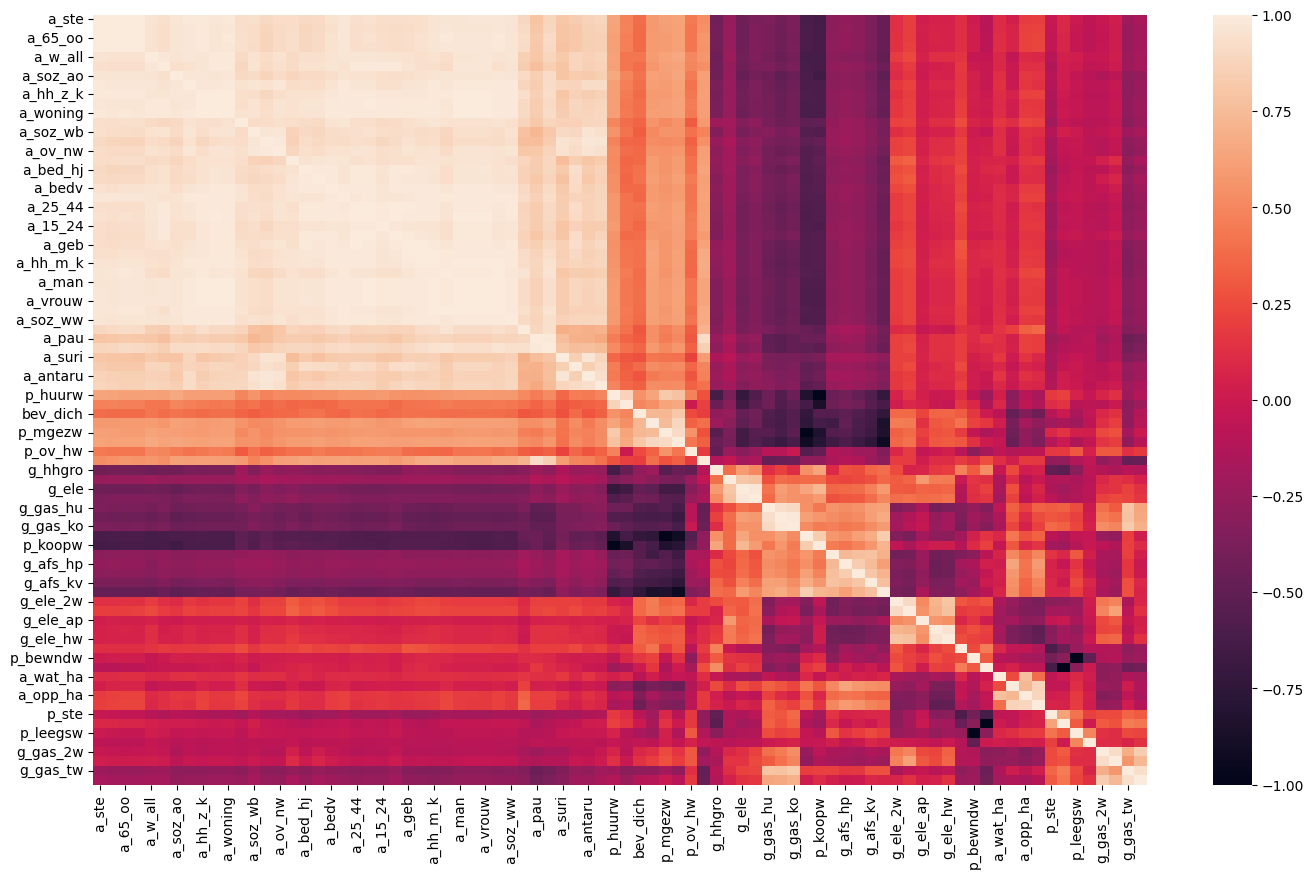

In [24]:
matrix = X_train.corr()
order = np.array(hierarchy.dendrogram(hierarchy.ward(matrix), no_plot=True)['ivl'], dtype="int")
matrix_h = X_train.iloc[:, order].corr()
plt.figure(figsize=(17, 10))
sns.heatmap(matrix_h)

In [25]:
linearRegression = make_pipeline(StandardScaler(), SelectKBest(k=5, score_func=f_regression), LinearRegression())
linearRegression.fit(X_train, y_train)
print("R^2: ", linearRegression.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test, linearRegression.predict(X_test)))
print("MAE: ", mean_absolute_error(y_test, linearRegression.predict(X_test)))
selected_features_mask = linearRegression.named_steps['selectkbest'].get_support()
selected_features = [feature for feature, is_selected in zip(X_train.columns, selected_features_mask) if is_selected]
print("Selected Features:", selected_features)
print("Coefficients:", linearRegression.named_steps['linearregression'].coef_)

R^2:  0.4200208292309139
MSE:  12.71510485125524
MAE:  2.767997990874559
Selected Features: ['g_hhgro', 'p_1gezw', 'p_mgezw', 'ste_mvs', 'ste_oad']
Coefficients: [-1.85729584  0.46097515 -0.46097515 -1.55427963  0.77665945]


In [26]:
lasso = make_pipeline(StandardScaler(), SelectKBest(k=3, score_func=f_regression), LassoCV(random_state=0))
lasso.fit(X_train, y_train)
print("R^2: ", lasso.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test, lasso.predict(X_test)))
print("MAE: ", mean_absolute_error(y_test, lasso.predict(X_test)))

R^2:  0.4140174866709845
MSE:  12.846718422836242
MAE:  2.7577501054090474


In [27]:
ridge = make_pipeline(StandardScaler(), SelectKBest(k=6, score_func=f_regression), RidgeCV(alphas=np.linspace(1, 100, 100)))
ridge.fit(X_train, y_train)
print("R^2: ", ridge.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test, ridge.predict(X_test)))
print("MAE: ", mean_absolute_error(y_test, ridge.predict(X_test)))

R^2:  0.40862948988169523
MSE:  12.964841534090723
MAE:  2.822060543751646


In [28]:
elastic = make_pipeline(StandardScaler(), SelectKBest(k=5, score_func=f_regression), ElasticNetCV())
elastic.fit(X_train, y_train)
print("R^2: ", elastic.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test, elastic.predict(X_test)))
print("MAE: ", mean_absolute_error(y_test, elastic.predict(X_test)))

R^2:  0.3889225932639865
MSE:  13.396883354583581
MAE:  2.829471865652138


In [29]:
param_grid = {"n_estimators": range(50, 105, 10), "max_features" : range(10, 65, 10), "max_depth": range(15, 35, 5)}
forest = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid)
forest.fit(X_train, y_train)
print("R^2: ", forest.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test, forest.predict(X_test)))
print("MAE: ", mean_absolute_error(y_test, forest.predict(X_test)))

R^2:  0.30926400016271227
MSE:  15.143269112270461
MAE:  3.0626896532806662


In [30]:
regions_predicted = linearRegression.predict(regions_to_predict[regions_to_predict.columns[1:-1]])
pd.Series(data=regions_predicted, index=regions_to_predict["regio"])

regio
Appingedam           44.996762
Delfzijl             43.663868
Achtkarspelen        39.585408
Ameland              41.994287
Harlingen            45.429028
                       ...    
De Fryske Marren     42.388136
Meierijstad          42.243960
Waadhoeke            41.933537
Westerwolde          41.344547
Noardeast-Fryslân    40.835927
Length: 108, dtype: float64

Max Score: 0.82
Optimal Clusters: 2


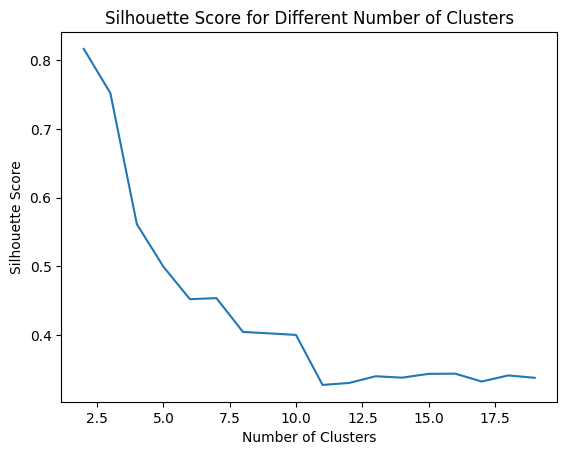

In [31]:
n = list(range(2, 20))
scores = []
for i in n:
  kmeans = KMeans(n_clusters = i)
  labels = kmeans.fit_predict(values)
  scores.append(silhouette_score(values, labels))
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
max_score_index = scores.index(max(scores))
max_score = scores[max_score_index]
optimal_clusters = n[max_score_index]
print(f'Max Score: {max_score:.2f}\nOptimal Clusters: {optimal_clusters}')
plt.plot(n, scores)


In [32]:
kmeans = KMeans(n_clusters = 2)
labels = kmeans.fit_predict(values)
print("Silhouette score:", silhouette_score(values, labels), '\n')
print("municipalities in first cluster:")
print(municipalities[labels==0], '\n')
print("municipalities in second cluster:")
print(municipalities[labels==1], '\n')

Silhouette score: 0.816747369619774 

municipalities in first cluster:
3             Loppersum
5           Stadskanaal
6               Veendam
7              Zeewolde
20                Assen
             ...       
349    Vijfheerenlanden
350      Hoeksche Waard
351        Het Hogeland
352      Westerkwartier
354         Molenlanden
Name: regio, Length: 235, dtype: object 

municipalities in second cluster:
2           Groningen
4              Almere
29           Enschede
46          Apeldoorn
68           Nijmegen
86         Amersfoort
99            Utrecht
119           Haarlem
120    Haarlemmermeer
144          Zaanstad
173         Rotterdam
207             Breda
Name: regio, dtype: object 



In [34]:
geojson_path = 'gadm41_NLD_2.json'
gdf = gpd.read_file(geojson_path)
gdf["NAME_2"][20] = "Dantumadiel"
gdf["NAME_2"][59] = "Neder-Betuwe"
gdf["NAME_2"][101] = "Bergen(L.)"
gdf["NAME_2"][195] = "Bergen(NH.)"
gdf["NAME_2"][254] = "Rijssen-Holten"
gdf["NAME_2"][87] = "Loppersum"

<ipython-input-34-597c37696d29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf["NAME_2"][20] = "Dantumadiel"
<ipython-input-34-597c37696d29>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf["NAME_2"][59] = "Neder-Betuwe"
<ipython-input-34-597c37696d29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf["NAME_2"][101] = "Bergen(L.)"
<ipython-input-34-597c37696d29>:6: SettingWithCopyWarning: 
A value is trying to be set on a 

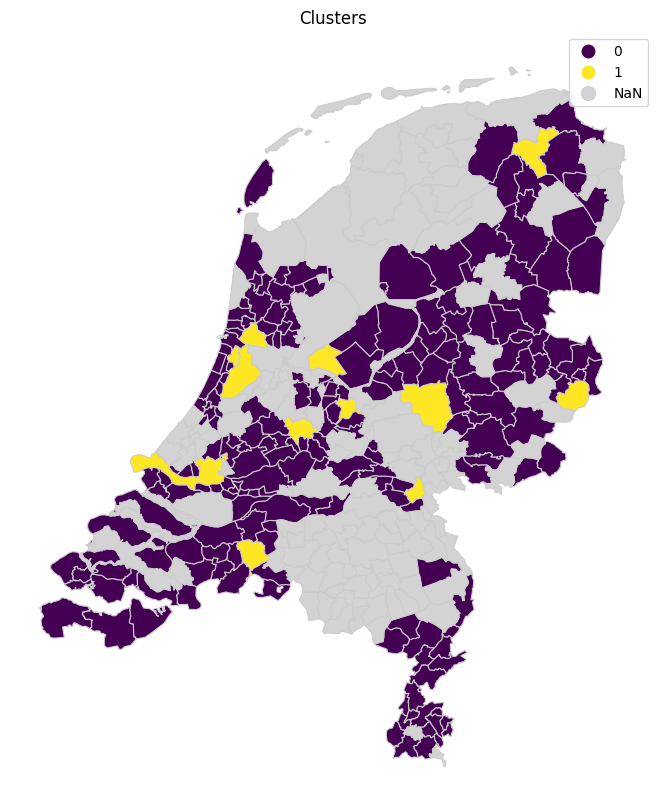

In [35]:
municipalities_labels = pd.DataFrame({"Municipalities": municipalities, "Labels": labels})
municipalities_labels["Labels"] = municipalities_labels["Labels"].astype(str)
merged = gdf.merge(municipalities_labels, left_on='NAME_2', right_on='Municipalities', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column='Labels', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, missing_kwds={'color': 'lightgray', 'label': 'NaN'})
ax.set_title('Clusters')
ax.set_axis_off()

plt.show()

In [36]:
isolation_forest = IsolationForest(contamination=0.05)
isolation_forest.fit(values)
outliers_prediction1 = isolation_forest.predict(values)
municipalities[outliers_prediction1 == -1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


2           Groningen
4              Almere
46          Apeldoorn
68           Nijmegen
86         Amersfoort
99            Utrecht
119           Haarlem
120    Haarlemmermeer
144          Zaanstad
163            Leiden
173         Rotterdam
207             Breda
254        Maastricht
Name: regio, dtype: object

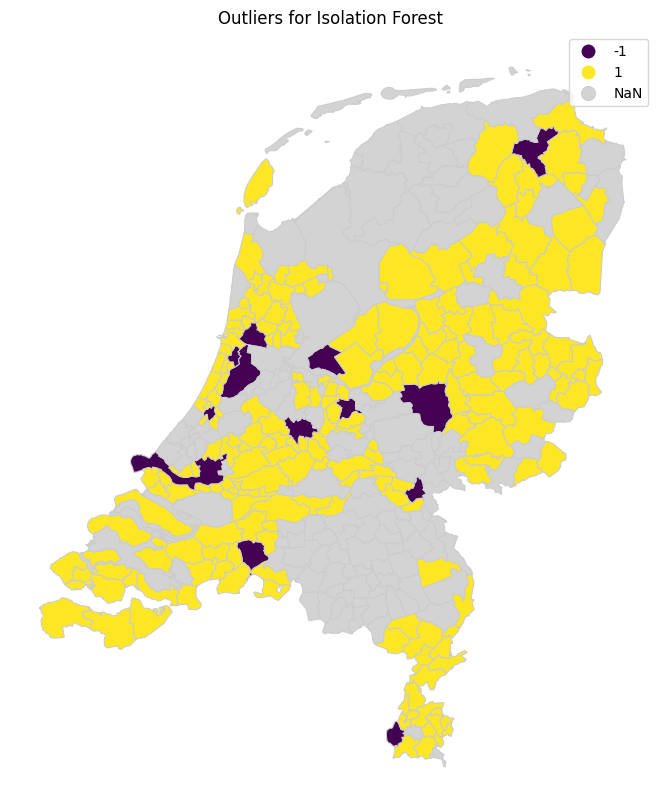

In [37]:
municipalities_outliers1 = pd.DataFrame({"Municipalities": municipalities, "Outliers": outliers_prediction1})
municipalities_outliers1["Outliers"] = municipalities_outliers1["Outliers"].astype(str)
merged = gdf.merge(municipalities_outliers1, left_on='NAME_2', right_on='Municipalities', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column='Outliers', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, missing_kwds={'color': 'lightgray', 'label': 'NaN'})
ax.set_title('Outliers for Isolation Forest ')
ax.set_axis_off()

plt.show()

In [38]:
one_class = OneClassSVM(nu=0.05)
one_class.fit(values)
outliers_prediction2 = one_class.predict(values)
municipalities[outliers_prediction2 == -1]

2              Groningen
4                 Almere
46             Apeldoorn
68              Nijmegen
99               Utrecht
120       Haarlemmermeer
163               Leiden
173            Rotterdam
185          Zoeterwoude
207                Breda
256    Mook en Middelaar
267             Lelystad
351         Het Hogeland
Name: regio, dtype: object

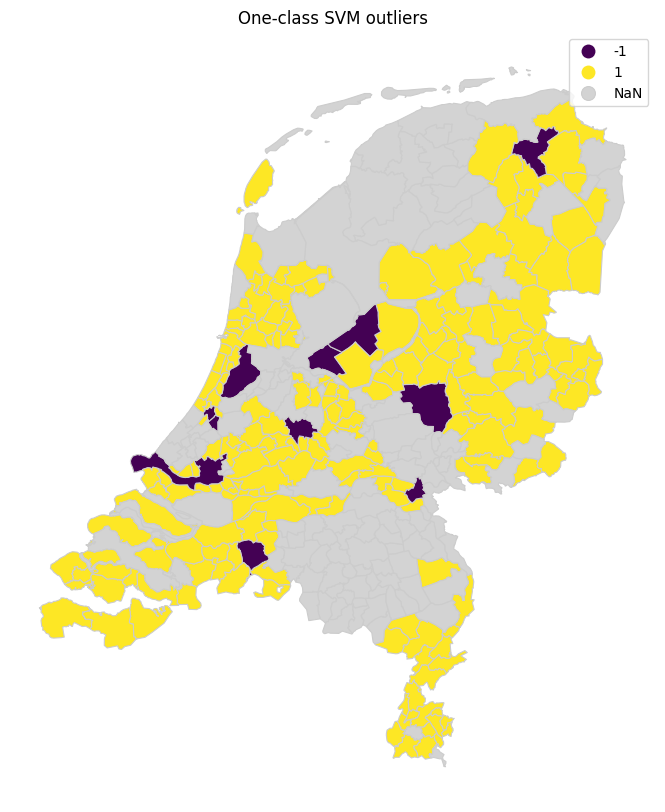

In [39]:
municipalities_outliers2 = pd.DataFrame({"Municipalities": municipalities, "Outliers": outliers_prediction2})
municipalities_outliers2["Outliers"] = municipalities_outliers2["Outliers"].astype(str)
merged = gdf.merge(municipalities_outliers2, left_on='NAME_2', right_on='Municipalities', how='left')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column='Outliers', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, missing_kwds={'color': 'lightgray', 'label': 'NaN'})
ax.set_title('One-class SVM outliers')
ax.set_axis_off()

plt.show()